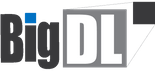

# Introduction
In this notebook we demonstrates how to use Nano HPO to tune the hyperparameters in tensorflow training. The model is built by subclassing tensorflow.keras.Model.


# Step0: Prepare Environment
You can install the latest pre-release version with nano support using below commands.

We recommend to run below commands, especially `source bigdl-nano-init` before jupyter kernel is started, or some of the optimizations may not take effect.

In [ ]:
# Install latest pre-release version of bigdl-nano
!pip install --pre bigdl-nano[tensorflow]
!pip install setuptools==58.0.4
!pip install protobuf==3.20.1
!source bigdl-nano-init

In [ ]:
# Install other dependecies for Nano HPO
!pip install ConfigSpace
!pip install optuna

# Step1: Init Nano AutoML
We need to enable Nano HPO before we use it for tensorflow training.

In [ ]:
import bigdl.nano.automl as automl
import bigdl.nano.automl.hpo as hpo
automl.hpo_config.enable_hpo_tf()

# Step2: Prepare data
We use fashion MNIST dataset for demonstration.

In [ ]:
from tensorflow import keras
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

CLASSES = 10

img_x, img_y = x_train.shape[1], x_train.shape[2]
x_train = x_train.reshape(-1, img_x, img_y,1).astype("float32") / 255
x_test = x_test.reshape(-1, img_x, img_y,1).astype("float32") / 255

# Step3: Build model and specify search spaces
We now create our model. 

Decorate the model class with hpo.tfmodel, and you will be able to specify search spaces in init arguments when creating the model, as shown below. For more details, refer to [user doc](https://bigdl.readthedocs.io/en/latest/doc/Nano/QuickStart/hpo.html).


In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Conv2D, Dropout, MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten

In [ ]:
import tensorflow as tf
@hpo.tfmodel()
class MyModel(tf.keras.Model):

    def __init__(self, filters, kernel_size, strides, activation):
        super().__init__()
        self.conv1 = Conv2D(
            filters=filters,
            kernel_size=kernel_size,
            strides=strides,
            activation=activation)
        self.pool1 = MaxPooling2D(pool_size=2)
        self.drop1 = Dropout(0.3)
        self.flat = Flatten()
        self.dense1 = Dense(256, activation='relu')
        self.drop3 = Dropout(0.5)
        self.dense2 = Dense(CLASSES, activation="softmax")

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.pool1(x)
        x = self.drop1(x)
        x = self.flat(x)
        x = self.dense1(x)
        x = self.drop3(x)
        x = self.dense2(x)
        return x
model = MyModel(
    filters=hpo.space.Categorical(32, 64),
    kernel_size=hpo.space.Categorical(2, 4),
    strides=hpo.space.Categorical(1, 2),
    activation=hpo.space.Categorical("relu", "linear")
)

# Step4: Compile model
We now compile our model with loss function, optimizer and metrics. If you want to tune learning rate and batch size, refer to [user guide](https://bigdl.readthedocs.io/en/latest/doc/Nano/QuickStart/hpo.html#search-the-learning-rate).

In [ ]:
from tensorflow.keras.optimizers import RMSprop
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=RMSprop(learning_rate=0.001),
    metrics=["accuracy"],
)

# Step5: Run hyperparameter search
Run hyperparameter search by calling `model.search`. Set the `target_metric` and `direction` so that HPO optimizes the `target_metric` in the specified `direction`. Each trial will use a different set of hyperparameters in the search space range. Use `n_parallels` to set the nubmer of parallel processes to run trials. After search completes, you can use `search_summary` to retrive the search results for analysis. For more details, refer to [user doc](https://bigdl.readthedocs.io/en/latest/doc/Nano/QuickStart/hpo.html).

In [ ]:
%%time
from bigdl.nano.automl.hpo.backend import PrunerType
model.search(
    n_trials=5,
    target_metric='val_accuracy',
    direction="maximize",
    pruner=PrunerType.HyperBand,
    pruner_kwargs={'min_resource':1, 'max_resource':100, 'reduction_factor':3},
    x=x_train,
    y=y_train,
    batch_size=128,
    epochs=5,
    validation_split=0.2,
    verbose=False,
)

In [ ]:
print(model.search_summary())

In [ ]:
study = model.search_summary()
study.trials_dataframe(attrs=("number", "value", "params", "state"))

# Step 6: fit with the best hyperparameters
After search, `model.fit` will autotmatically use the best hyperparmeters found in search to fit the model.

In [ ]:
history = model.fit(x_train, y_train,
                    batch_size=128, epochs=5, validation_split=0.2)

test_scores = model.evaluate(x_test, y_test, verbose=2)
print("Test loss:", test_scores[0])
print("Test accuracy:", test_scores[1])

Check out the summary of the model. The model has already been built with the best hyperparameters found by nano hpo.

In [ ]:
study = model.search_summary()
study.trials_dataframe(attrs=("number", "value", "params", "state"))